In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

In [2]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir) 

>> Downloading flowers.tar.gz 100.0%
Successfully downloaded flowers.tar.gz 228649660 bytes.


### Display some of the data.

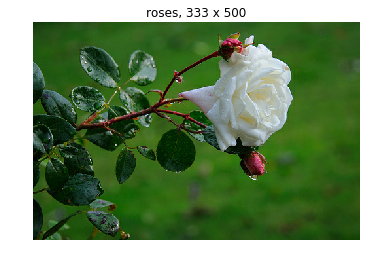

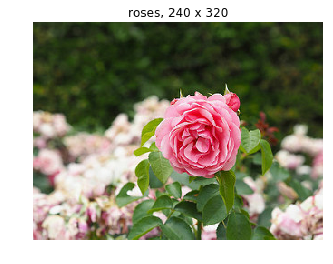

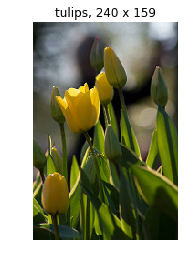

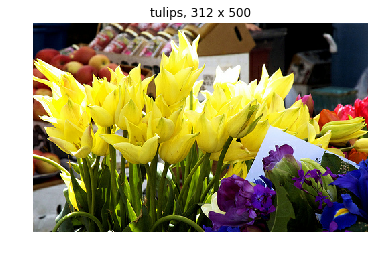

In [3]:
from datasets import flowers
import tensorflow as tf

from tensorflow.contrib import slim

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

# Convolutional neural nets (CNNs).
<a id='CNN'></a>

In this section, we show how to train an image classifier using a simple CNN.


### Define the model.

Below we define a simple CNN. Note that the output layer is linear function - we will apply softmax transformation externally to the model, either in the loss function (for training), or in the prediction function (during testing).

In [4]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

# Using pre-trained models
<a id='Pretrained'></a>

Neural nets work best when they have many parameters, making them very flexible function approximators.
However, this  means they must be trained on big datasets. Since this process is slow, we provide various pre-trained models - see the list [here](https://github.com/tensorflow/models/tree/master/slim#pre-trained-models).


You can either use these models as-is, or you can perform "surgery" on them, to modify them for some other task. For example, it is common to "chop off" the final pre-softmax layer, and replace it with a new set of weights corresponding to some new set of labels. You can then quickly fine tune the new model on a small new dataset. We illustrate this below, using inception-v1 as the base model. While models like Inception V3 are more powerful, Inception V1 is used for speed purposes.

Take into account that VGG and ResNet final layers have only 1000 outputs rather than 1001. The ImageNet dataset provied has an empty background class which can be used to fine-tune the model to other tasks. VGG and ResNet models provided here don't use that class. We provide two examples of using pretrained models: Inception V1 and VGG-19 models to highlight this difference.


### Download the Inception V1 checkpoint




In [5]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.


### Fine-tune the model on a different set of labels.

We will fine tune the inception model on the Flowers dataset.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from os import listdir, path, makedirs
from os.path import isfile, isdir, join, basename

base_path = '/Users/ali.jeon/gitlab/ocr/preprocessing/phd08_output'

def read_charlist(base_path):
    data_filenames = [path.splitext(f)[0] for f in listdir(base_path) if isfile(join(base_path, f)) and f.lower().endswith('.csv')]        
    
    return data_filenames
        
data_filenames = read_charlist(base_path)
data_filenames = data_filenames[:20]

label_idx = {x:idx for idx, x in enumerate(sorted(data_filenames))}
label_name = {idx:x for idx, x in enumerate(sorted(data_filenames))}

def get_inputs(batch_size=1024, height=56, width=56, is_training=False):
    # Create a queue that produces the filenames to read.
    filenames = [join(base_path, '.'.join([char, 'csv'])) for char in data_filenames]
    filename_queue = tf.train.string_input_producer(filenames)
    line_reader = tf.TextLineReader()
    # Read a whole file from the queue, the first returned value in the tuple is the
    # filename which we are ignoring.
    _, csv_row = line_reader.read(filename_queue)
    
    '''
        Columns:
        FO(1): Font type (B:바다, D:돋움, G:고딕, H1:한양해서, H2:헤드라인, M:명조, N:나무, S:샘물, Y:엽서)
        FS(1): Font size (0:12, 1:13: 2:14)
        CP(1): The number of copies (0:0, 1:1, 2:2)
        RE(1): Resolution (0:200, 1:240, 2:280)
        TH(1): Threshold (0:140, 1:180, 2:220)
        SL(1): Slope(Rotate) (0:-3deg, 1:0deg, 2:3deg)
        HE(1): Height(pixels)
        WD(1): Width(pixels)
        Korean Character(1) (가, 각, 간, ...)
        Image data(The number of columns = Rows X Cols)
        Label(1): (0:가, 1:각, 2:간 ...)

    '''
    record_defaults = [
        [''], # FO
        [''], # FS
        [0],  # CP
        [0],  # RE
        [0],  # TH
        [0],  # SL
        [0],  # HE
        [0],  # WD
        [''],  # Kor char.
    ] + [[0]] * (56*56) + [[0]]

    columns = tf.decode_csv(csv_row, record_defaults=record_defaults)
    character = columns[8]
    image_raw = tf.reshape(tf.stack(columns[9:-1]), [56, 56, 1])
    image_raw = tf.cast(image_raw, tf.float32)
    image_raw = tf.image.grayscale_to_rgb(image_raw)
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)
    
    label = columns[-1]
    
    '''
    To check valid input
    '''
    num_preprocess_threads = 1
    min_queue_examples = 256
    
    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

get_inputs()

(<tf.Tensor 'batch:0' shape=(32, 56, 56, 3) dtype=float32>,
 <tf.Tensor 'batch:1' shape=(32, 56, 56, 3) dtype=float32>,
 <tf.Tensor 'batch:2' shape=(32,) dtype=int32>)

In [11]:
NUM_CLASSES = len(label_idx)
NUM_CLASSES

20

In [16]:
label_name = {idx:x for idx, x in enumerate(sorted(data_filenames))}

In [20]:
# Note that this may take several minutes.

import os

import tensorflow as tf

from datasets import flowers
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v1.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)


train_dir = '/tmp/inception_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    images, _, labels = get_inputs(height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=NUM_CLASSES, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, NUM_CLASSES)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
    
    tf.summary.histogram('labels', labels)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=1000)
        
  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-11
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/inception_finetuned/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 11.
INFO:tensorflow:global step 12: loss = 20.7159 (16.178 sec/step)
INFO:tensorflow:global step 13: loss = 14.6768 (9.966 sec/

INFO:tensorflow:global step 101: loss = 0.7305 (8.588 sec/step)
INFO:tensorflow:global step 102: loss = 0.7240 (8.471 sec/step)
INFO:tensorflow:global step 103: loss = 0.7267 (8.602 sec/step)
INFO:tensorflow:global step 104: loss = 0.7287 (8.434 sec/step)
INFO:tensorflow:global step 105: loss = 0.7328 (8.441 sec/step)
INFO:tensorflow:global step 106: loss = 0.7322 (8.752 sec/step)
INFO:tensorflow:global step 107: loss = 0.7335 (8.472 sec/step)
INFO:tensorflow:global step 108: loss = 0.7347 (8.707 sec/step)
INFO:tensorflow:global step 109: loss = 0.7355 (8.727 sec/step)
INFO:tensorflow:global step 110: loss = 0.7359 (8.218 sec/step)
INFO:tensorflow:global step 111: loss = 0.7364 (8.759 sec/step)
INFO:tensorflow:global step 112: loss = 0.7366 (8.457 sec/step)
INFO:tensorflow:global step 113: loss = 0.7366 (8.341 sec/step)
INFO:tensorflow:global step 114: loss = 0.7366 (8.702 sec/step)
INFO:tensorflow:global step 115: loss = 0.7365 (8.505 sec/step)
INFO:tensorflow:global step 116: loss = 

INFO:tensorflow:global step 224: loss = 1.4301 (8.910 sec/step)
INFO:tensorflow:global step 225: loss = 1.2912 (8.777 sec/step)
INFO:tensorflow:global step 226: loss = 1.1291 (8.555 sec/step)
INFO:tensorflow:global step 227: loss = 1.0785 (8.333 sec/step)
INFO:tensorflow:global step 228: loss = 1.0284 (8.716 sec/step)
INFO:tensorflow:global step 229: loss = 0.9146 (8.579 sec/step)
INFO:tensorflow:global step 230: loss = 0.9149 (8.612 sec/step)
INFO:tensorflow:global step 231: loss = 0.8693 (8.762 sec/step)
INFO:tensorflow:global step 232: loss = 0.8623 (8.617 sec/step)
INFO:tensorflow:global step 233: loss = 0.8646 (8.490 sec/step)
INFO:tensorflow:global step 234: loss = 0.8551 (8.773 sec/step)
INFO:tensorflow:global step 235: loss = 0.8569 (8.570 sec/step)
INFO:tensorflow:global step 236: loss = 0.8535 (8.467 sec/step)
INFO:tensorflow:global step 237: loss = 0.8536 (8.694 sec/step)
INFO:tensorflow:global step 238: loss = 0.8638 (8.685 sec/step)
INFO:tensorflow:global step 239: loss = 

INFO:tensorflow:global step 350: loss = 16.6300 (8.570 sec/step)
INFO:tensorflow:global step 351: loss = 13.9271 (8.710 sec/step)
INFO:tensorflow:global step 352: loss = 11.3155 (8.386 sec/step)
INFO:tensorflow:global step 353: loss = 7.9454 (9.367 sec/step)
INFO:tensorflow:global step 354: loss = 5.2946 (9.021 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/inception_finetuned/model.ckpt
INFO:tensorflow:global_step/sec: 0.111606
INFO:tensorflow:Recording summary at step 354.
INFO:tensorflow:global step 355: loss = 4.2278 (10.880 sec/step)
INFO:tensorflow:global step 356: loss = 3.5848 (11.966 sec/step)
INFO:tensorflow:global step 357: loss = 3.0435 (9.320 sec/step)
INFO:tensorflow:global step 358: loss = 2.4488 (7.402 sec/step)
INFO:tensorflow:global step 359: loss = 2.2146 (5.670 sec/step)
INFO:tensorflow:global step 360: loss = 2.2429 (8.921 sec/step)
INFO:tensorflow:global step 361: loss = 2.0885 (9.598 sec/step)
INFO:tensorflow:global step 362: loss = 1.8999 (8.556 sec/st

INFO:tensorflow:global step 473: loss = 0.9579 (8.648 sec/step)
INFO:tensorflow:global step 474: loss = 0.9560 (8.597 sec/step)
INFO:tensorflow:global step 475: loss = 0.9541 (8.850 sec/step)
INFO:tensorflow:global step 476: loss = 0.9523 (8.654 sec/step)
INFO:tensorflow:global step 477: loss = 0.9504 (8.526 sec/step)
INFO:tensorflow:global step 478: loss = 0.9485 (8.781 sec/step)
INFO:tensorflow:global step 479: loss = 0.9467 (8.719 sec/step)
INFO:tensorflow:global step 480: loss = 0.9447 (8.591 sec/step)
INFO:tensorflow:global step 481: loss = 0.9428 (8.662 sec/step)
INFO:tensorflow:global step 482: loss = 0.9409 (8.464 sec/step)
INFO:tensorflow:global step 483: loss = 8.7064 (8.754 sec/step)
INFO:tensorflow:global step 484: loss = 29.2311 (8.539 sec/step)
INFO:tensorflow:global step 485: loss = 22.0990 (8.746 sec/step)
INFO:tensorflow:global step 486: loss = 16.0369 (8.744 sec/step)
INFO:tensorflow:global step 487: loss = 11.7859 (8.380 sec/step)
INFO:tensorflow:global step 488: los

INFO:tensorflow:global step 597: loss = 0.9931 (8.963 sec/step)
INFO:tensorflow:global step 598: loss = 0.9912 (8.893 sec/step)
INFO:tensorflow:global step 599: loss = 0.9892 (8.566 sec/step)
INFO:tensorflow:global step 600: loss = 0.9873 (8.931 sec/step)
INFO:tensorflow:global step 601: loss = 0.9854 (8.416 sec/step)
INFO:tensorflow:global step 602: loss = 0.9840 (8.796 sec/step)
INFO:tensorflow:global step 603: loss = 0.9816 (8.738 sec/step)
INFO:tensorflow:global step 604: loss = 0.9796 (8.537 sec/step)
INFO:tensorflow:global step 605: loss = 0.9777 (8.556 sec/step)
INFO:tensorflow:global step 606: loss = 0.9756 (8.607 sec/step)
INFO:tensorflow:global step 607: loss = 0.9737 (8.291 sec/step)
INFO:tensorflow:global step 608: loss = 0.9715 (8.919 sec/step)
INFO:tensorflow:global step 609: loss = 0.9695 (9.217 sec/step)
INFO:tensorflow:global step 610: loss = 0.9683 (8.806 sec/step)
INFO:tensorflow:global step 611: loss = 0.9667 (8.880 sec/step)
INFO:tensorflow:global step 612: loss = 

INFO:tensorflow:global step 721: loss = 1.0367 (8.510 sec/step)
INFO:tensorflow:global step 722: loss = 1.0356 (8.857 sec/step)
INFO:tensorflow:global step 723: loss = 0.9645 (8.503 sec/step)
INFO:tensorflow:global step 724: loss = 0.9409 (8.753 sec/step)
INFO:tensorflow:global step 725: loss = 0.9652 (8.855 sec/step)
INFO:tensorflow:global step 726: loss = 0.9486 (8.512 sec/step)
INFO:tensorflow:global step 727: loss = 0.9699 (8.479 sec/step)
INFO:tensorflow:global step 728: loss = 0.9376 (8.655 sec/step)
INFO:tensorflow:global step 729: loss = 0.9259 (8.750 sec/step)
INFO:tensorflow:global step 730: loss = 0.9526 (8.408 sec/step)
INFO:tensorflow:global step 731: loss = 0.9662 (8.797 sec/step)
INFO:tensorflow:global step 732: loss = 0.9289 (8.607 sec/step)
INFO:tensorflow:global step 733: loss = 0.9252 (8.479 sec/step)
INFO:tensorflow:global step 734: loss = 0.9478 (9.002 sec/step)
INFO:tensorflow:global step 735: loss = 0.9125 (8.561 sec/step)
INFO:tensorflow:global step 736: loss = 

INFO:tensorflow:global step 845: loss = 0.8701 (8.595 sec/step)
INFO:tensorflow:global step 846: loss = 0.8667 (8.430 sec/step)
INFO:tensorflow:global step 847: loss = 0.8677 (9.148 sec/step)
INFO:tensorflow:global step 848: loss = 0.8667 (13.215 sec/step)
INFO:tensorflow:global step 849: loss = 0.8658 (11.907 sec/step)
INFO:tensorflow:global step 850: loss = 0.8642 (9.278 sec/step)
INFO:tensorflow:global step 851: loss = 0.8637 (8.728 sec/step)
INFO:tensorflow:global step 852: loss = 0.8629 (7.811 sec/step)
INFO:tensorflow:global step 853: loss = 0.8621 (8.667 sec/step)
INFO:tensorflow:global step 854: loss = 0.8611 (8.602 sec/step)
INFO:tensorflow:global step 855: loss = 0.8600 (8.335 sec/step)
INFO:tensorflow:global step 856: loss = 0.8589 (8.606 sec/step)
INFO:tensorflow:global step 857: loss = 0.8585 (8.908 sec/step)
INFO:tensorflow:global step 858: loss = 0.8588 (8.442 sec/step)
INFO:tensorflow:global step 859: loss = 0.8551 (8.512 sec/step)
INFO:tensorflow:global step 860: loss 

INFO:tensorflow:Recording summary at step 969.
INFO:tensorflow:global step 970: loss = 0.9206 (10.860 sec/step)
INFO:tensorflow:global step 971: loss = 0.9075 (12.950 sec/step)
INFO:tensorflow:global step 972: loss = 0.9109 (9.026 sec/step)
INFO:tensorflow:global step 973: loss = 0.9157 (8.888 sec/step)
INFO:tensorflow:global step 974: loss = 0.9195 (9.317 sec/step)
INFO:tensorflow:global step 975: loss = 0.9234 (8.071 sec/step)
INFO:tensorflow:global step 976: loss = 0.9266 (5.598 sec/step)
INFO:tensorflow:global step 977: loss = 0.9290 (6.673 sec/step)
INFO:tensorflow:global step 978: loss = 0.9310 (8.548 sec/step)
INFO:tensorflow:global step 979: loss = 0.9329 (8.522 sec/step)
INFO:tensorflow:global step 980: loss = 0.9341 (8.639 sec/step)
INFO:tensorflow:global step 981: loss = 0.9350 (8.621 sec/step)
INFO:tensorflow:global step 982: loss = 0.9355 (8.602 sec/step)
INFO:tensorflow:global step 983: loss = 0.9357 (8.572 sec/step)
INFO:tensorflow:global step 984: loss = 0.9357 (8.618 s

### Apply fine tuned model to some images.

Instructions for updating:
Use `tf.local_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-1000
16 17 갚 갛


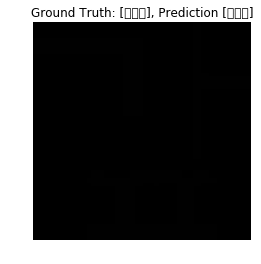

16 17 갚 갛


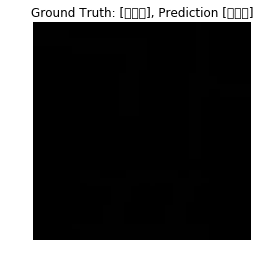

16 17 갚 갛


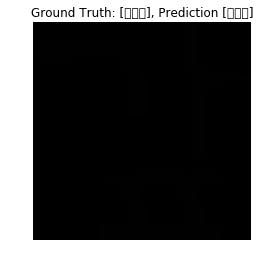

16 17 갚 갛


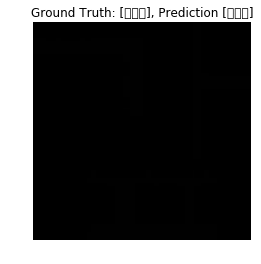

16 17 갚 갛


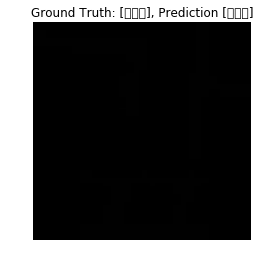

16 17 갚 갛


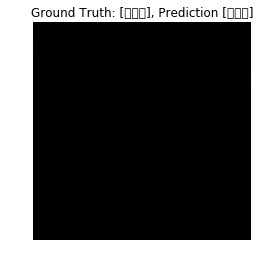

16 17 갚 갛


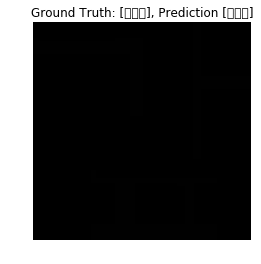

16 17 갚 갛


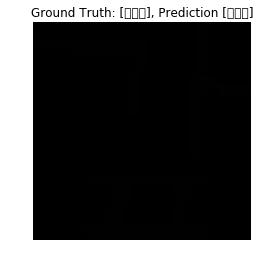

16 17 갚 갛


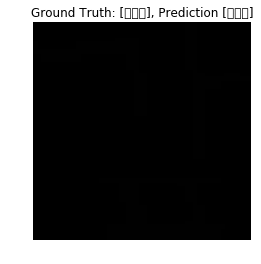

16 17 갚 갛


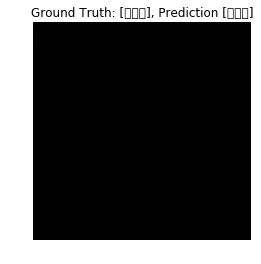

16 17 갚 갛


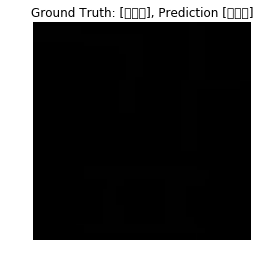

16 17 갚 갛


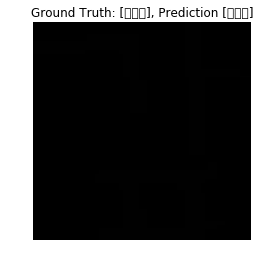

16 17 갚 갛


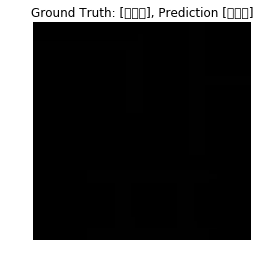

16 17 갚 갛


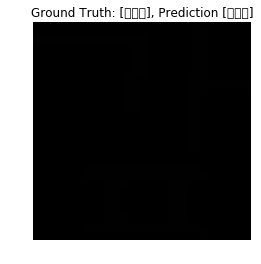

16 17 갚 갛


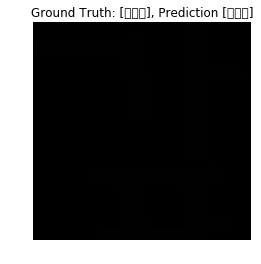

16 17 갚 갛


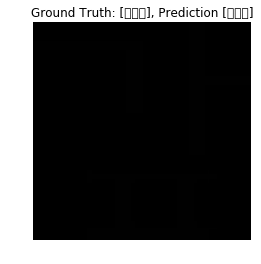

16 17 갚 갛


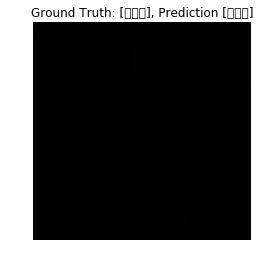

16 17 갚 갛


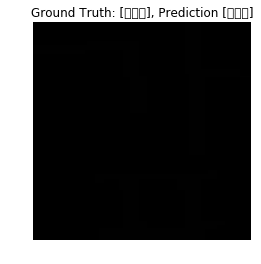

16 17 갚 갛


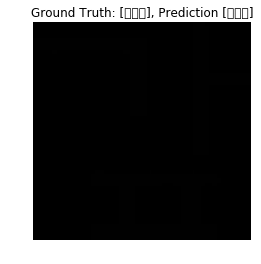

16 17 갚 갛


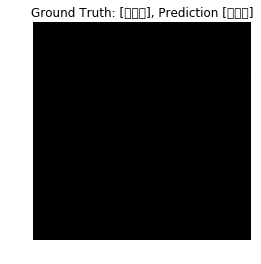

16 17 갚 갛


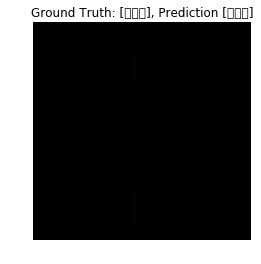

16 17 갚 갛


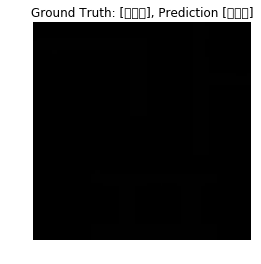

16 17 갚 갛


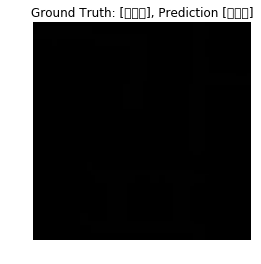

16 17 갚 갛


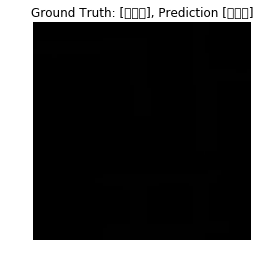

16 17 갚 갛


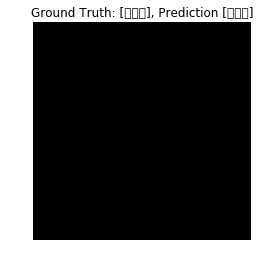

16 17 갚 갛


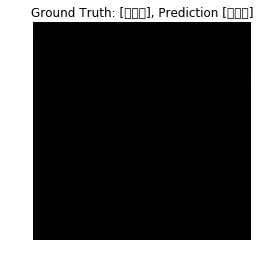

16 17 갚 갛


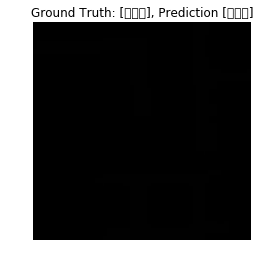

16 17 갚 갛


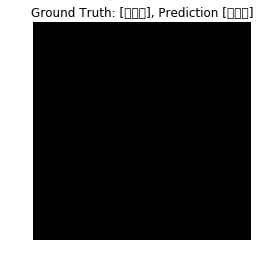

16 17 갚 갛


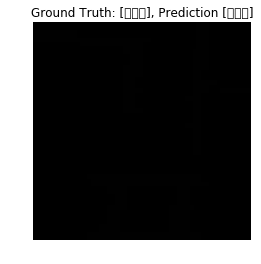

16 17 갚 갛


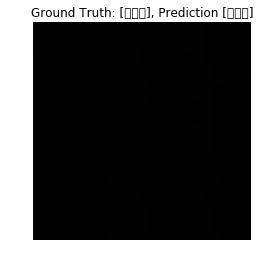

16 17 갚 갛


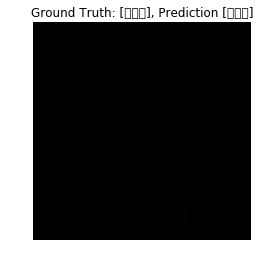

16 17 갚 갛


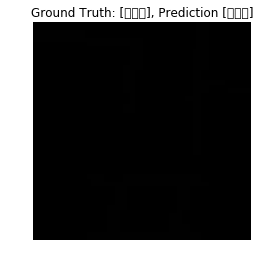

In [23]:
import numpy as np
import tensorflow as tf
from datasets import flowers
from nets import inception

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size
batch_size = 32

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    images, images_raw, labels = get_inputs(height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=NUM_CLASSES, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = label_name[predicted_label]
                true_name = label_name[true_label]
                
                print(true_label, predicted_label, true_name, predicted_name)
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()